In [39]:
from google.colab import files
uploaded = files.upload()

Saving games_march2025_cleaned_NEW.csv to games_march2025_cleaned_NEW (2).csv


In [40]:
import numpy as np
import pandas as pd

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, low_memory=False)
print(df.shape)
df.head()

(72563, 22)


,appid,required_age,price,dlc_count,windows,mac,linux,achievements,recommendations,supported_languages,...,publishers,categories,genres,user_score,positive,negative,estimated_owners,peak_ccu,tags,num_reviews_total
0,730,0,0.00,1,1,0,1,1,4401572,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...",...,['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",0,7480813,1135108,150000000.0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",8632939.0
1,578080,0,0.00,0,1,0,0,37,1732007,"['English', 'Korean', 'Simplified Chinese', 'F...",...,"['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",0,1487960,1024436,75000000.0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",2513842.0
2,570,0,0.00,2,1,1,1,0,14337,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...",...,['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",0,1998462,451338,350000000.0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",2452595.0
3,271590,17,0.00,0,1,0,0,77,1803063,"['English', 'French', 'Italian', 'German', 'Sp...",...,['Rockstar Games'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",0,1719950,250012,75000000.0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",1803832.0
4,359550,17,3.99,9,1,0,0,0,1165929,"['English', 'French', 'Italian', 'German', 'Sp...",...,['Ubisoft'],"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],0,1152763,218446,35000000.0,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",1168020.0


In [41]:
owners = df["estimated_owners"].astype(float)
N = len(df)
print("N games:", N)

owners_rank = owners.rank(method="first") / N   # in (0, 1]

# 25% / 50% / 25%
q1 = 0.25
q2 = 0.75
print("Rank thresholds q1:", q1, " q2:", q2)

def make_pop_class_from_rank(r):
    if r <= q1:
        return 0    # low popularity
    elif r >= q2:
        return 2    # high popularity
    else:
        return 1    # medium popularity

df["pop_class"] = owners_rank.apply(make_pop_class_from_rank)

print(df["pop_class"].value_counts(normalize=True))
print(df["pop_class"].value_counts())

N games: 72563
Rank thresholds q1: 0.25  q2: 0.75
pop_class
1    0.500007
2    0.250003
0    0.249990
Name: proportion, dtype: float64
pop_class
1    36282
2    18141
0    18140
Name: count, dtype: int64


In [42]:
import ast
import re
from collections import Counter

# Build one-hot

def parse_list_col(s):
    if pd.isna(s):
        return []
    s = str(s).strip()
    if s == "" or s == "[]":
        return []
    try:
        obj= ast.literal_eval(s)
        if isinstance(obj, list):
            return [str(x).strip() for x in obj]
        else:
            return []
    except Exception:
        return []

def safe_col_name(s):
    # Make a safe column name for pandas.
    s = re.sub(r"[^0-9a-zA-Z]+", "_", s.strip())
    return s[:60]

# Parse categories into lists
cat_lists =df["categories"].apply(parse_list_col)

# Pick top M most common categories (avoid creating 7000+ columns)
M = 100 # i try 50, 100, 200
cnt= Counter()
for lst in cat_lists:
    cnt.update(lst)

top_cats= [c for c, _ in cnt.most_common(M)]
print("Top categories example:", top_cats[:10])

# Create multi-hot columns
for c in top_cats:
    col= "cat_" + safe_col_name(c)
    df[col]= cat_lists.apply(lambda lst: 1 if c in lst else 0).astype(int)

Top categories example: ['Single-player', 'Family Sharing', 'Steam Achievements', 'Steam Cloud', 'Full controller support', 'Multi-player', 'Steam Trading Cards', 'Partial Controller Support', 'PvP', 'Co-op']


In [43]:
import numpy as np

#Collect numeric feature columns
numeric_cols = [c for c in df.columns if df[c].dtype != "object"]
print("All numeric columns:", numeric_cols)

cat_cols = [c for c in df.columns if c.startswith("cat_")]
print("Num category one hot cols:", len(cat_cols))

exclude_cols = [
    "appid",
    "estimated_owners",
    "pop_class"
]

feature_cols = [c for c in numeric_cols if c not in exclude_cols]
print("Feature columns:", feature_cols)

df_ml = df[feature_cols + ["pop_class"]].dropna()
print("after dropna:", df_ml.shape)

X = df_ml[feature_cols].values
y = df_ml["pop_class"].astype(int).values
K = len(np.unique(y))
print("X shape:", X.shape, " y shape:", y.shape, " num classes:", K)

All numeric columns: ['appid', 'required_age', 'price', 'dlc_count', 'windows', 'mac', 'linux', 'achievements', 'recommendations', 'user_score', 'positive', 'negative', 'estimated_owners', 'peak_ccu', 'num_reviews_total', 'pop_class', 'cat_Single_player', 'cat_Family_Sharing', 'cat_Steam_Achievements', 'cat_Steam_Cloud', 'cat_Full_controller_support', 'cat_Multi_player', 'cat_Steam_Trading_Cards', 'cat_Partial_Controller_Support', 'cat_PvP', 'cat_Co_op', 'cat_Steam_Leaderboards', 'cat_Remote_Play_Together', 'cat_Online_PvP', 'cat_Shared_Split_Screen', 'cat_Tracked_Controller_Support', 'cat_VR_Only', 'cat_Online_Co_op', 'cat_Shared_Split_Screen_PvP', 'cat_Stats', 'cat_Shared_Split_Screen_Co_op', 'cat_Remote_Play_on_TV', 'cat_Steam_Workshop', 'cat_Cross_Platform_Multiplayer', 'cat_Includes_level_editor', 'cat_In_App_Purchases', 'cat_Captions_available', 'cat_VR_Supported', 'cat_Remote_Play_on_Tablet', 'cat_MMO', 'cat_Remote_Play_on_Phone', 'cat_LAN_Co_op', 'cat_LAN_PvP', 'cat_Commentary_

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Split train / test

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

print("Train:", X_tr.shape, "  Test:", X_te.shape)


# Standardize features


scaler = StandardScaler()
X_tr_std= scaler.fit_transform(X_tr)
X_te_std= scaler.transform(X_te)

def add_bias(X):
    n= X.shape[0]
    return np.hstack([np.ones((n, 1)), X])

X_tr_std= add_bias(X_tr_std)
X_te_std= add_bias(X_te_std)

print("After adding bias, X_tr shape:", X_tr_std.shape, " X_te shape:", X_te_std.shape)

Train: (35238, 53)   Test: (8810, 53)
After adding bias, X_tr shape: (35238, 54)  X_te shape: (8810, 54)


In [45]:
import numpy as np

# Use standardized train data with bias
Xg = X_tr_std # (N, d)
yg = y_tr #(N,)

N, d = Xg.shape
K = len(np.unique(yg))

print("N =", N, " d =", d, " K =", K)

N = 35238  d = 54  K = 3


In [46]:
def softmax_probs(W):

    #Compute P (N x K) for weights W (d x K).

    S = Xg @ W  # scores, shape (N, K)
    S= S- S.max(axis=1, keepdims=True)
    expS= np.exp(S)
    P= expS/expS.sum(axis=1, keepdims=True)
    return P


def softmax_loss(W):

    # loss for softmax

    P =softmax_probs(W)  # (N, K)
    idx = np.arange(N)
    # log-likelihood of the true class
    loss = -np.mean(np.log(P[idx, yg] + 1e-12))
    return loss

# Gradient of the softmax loss
def softmax_grad(W):

    P =softmax_probs(W)

    # one-hot
    Y_onehot= np.zeros_like(P)
    idx= np.arange(N)
    Y_onehot[idx, yg] = 1

    # gradient (d x K)
    G = Xg.T @ (P - Y_onehot) / N
    return G


In [47]:
def grad_descent(f, grad, W0, alpha, niter):
    W = W0.copy()
    f_hist=[]
    for it in range(niter):
        fval= f(W)
        g =grad(W)
        W = W -alpha * g
        f_hist.append(fval)
        if (it% 100 ==0) or (it== niter -1):
            print("iter %d, loss = %.6f" % (it, fval))
    return W, f_hist

In [48]:
# Initialize weights
rng = np.random.default_rng(0)
W0 = 0.01 * rng.standard_normal(size=(d, K))

# Hyperparameters
alpha = 1e-2 # if loss explodes, reduce this nunber
niter = 1000  # number of iter

W_hat, f_hist= grad_descent(softmax_loss, softmax_grad, W0, alpha, niter)

iter 0, loss = 1.094096
iter 100, loss = 1.033656
iter 200, loss = 1.012726
iter 300, loss = 1.002641
iter 400, loss = 0.997137
iter 500, loss = 0.993880
iter 600, loss = 0.991817
iter 700, loss = 0.990423
iter 800, loss = 0.989419
iter 900, loss = 0.988653
iter 999, loss = 0.988042


In [49]:
def softmax_predict(X, W):
    #Predict class labels for data X using weights W.
    S = X @ W
    S =S - S.max(axis=1, keepdims=True)
    expS = np.exp(S)
    P = expS /expS.sum(axis=1, keepdims=True)
    y_hat =np.argmax(P, axis=1)
    return y_hat

# Train accuracy
y_tr_hat = softmax_predict(X_tr_std, W_hat)
train_acc= np.mean(y_tr_hat == y_tr)
print("Train accuracy:", train_acc)

# Test accuracy
y_te_hat = softmax_predict(X_te_std, W_hat)
test_acc= np.mean(y_te_hat == y_te)
print("Test  accuracy:", test_acc)

Train accuracy: 0.5256541233895227
Test  accuracy: 0.5191827468785472


In [50]:
# Report ready summary

print("Summary (Softmax Regression Baseline)")
print("N train:", len(y_tr), "N test:", len(y_te))
print("Num features (with bias):", X_tr_std.shape[1])
print("Num classes K:", len(np.unique(y_tr)))

print("Train acc:", train_acc)
print("Test  acc:", test_acc)

# Majority baseline on TEST
maj = np.bincount(y_tr).argmax()
y_te_base = np.full_like(y_te, maj)
base_acc = np.mean(y_te_base == y_te)

print("Majority class (from train):", maj)
print("Baseline test acc (all majority):", base_acc)
print("Improvement over baseline:", test_acc - base_acc)

Summary (Softmax Regression Baseline)
N train: 35238 N test: 8810
Num features (with bias): 54
Num classes K: 3
Train acc: 0.5256541233895227
Test  acc: 0.5191827468785472
Majority class (from train): 0
Baseline test acc (all majority): 0.41180476730987514
Improvement over baseline: 0.10737797956867201


In [51]:
maj = np.bincount(y_tr).argmax() # majority class from TRAIN
y_te_base = np.full_like(y_te, maj)# predict all as majority
base_acc =np.mean(y_te_base == y_te)

print("Majority class:", maj)
print("Baseline (all majority) test accuracy:", base_acc)
print("Model test accuracy:", test_acc)
print("Improvement:", test_acc - base_acc)

Majority class: 0
Baseline (all majority) test accuracy: 0.41180476730987514
Model test accuracy: 0.5191827468785472
Improvement: 0.10737797956867201


In [52]:
# Confusion matrix + per-class precision/recall (no sklearn)
K = len(np.unique(y_tr))

cm = np.zeros((K, K), dtype=int)
for t, p in zip(y_te, y_te_hat):
    cm[int(t), int(p)] += 1

print("Confusion matrix (rows=true, cols=pred):")
print(cm)

eps = 1e-12
for k in range(K):
    tp =cm[k, k]
    prec = tp /(cm[:, k].sum() + eps)
    rec = tp /(cm[k, :].sum() + eps)
    print("Class", k, "precision:", prec, "recall:", rec)

Confusion matrix (rows=true, cols=pred):
[[2984    1  643]
 [1742    1  444]
 [1406    0 1589]]
Class 0 precision: 0.48662752772341805 recall: 0.8224917309812567
Class 1 precision: 0.49999999999975 recall: 0.00045724737082761756
Class 2 precision: 0.5937967115097158 recall: 0.5305509181969948


In [53]:
# Macro-F1 (no sklearn)
K = len(np.unique(y_tr))
eps = 1e-12

# cm already computed above, otherwise recompute quickly:
# cm = np.zeros((K, K), dtype=int)
# for t, p in zip(y_te, y_te_hat):
# cm[int(t), int(p)] += 1

prec= np.zeros(K)
rec = np.zeros(K)
f1 = np.zeros(K)

for k in range(K):
    tp = cm[k, k]
    prec[k]= tp / (cm[:, k].sum() + eps)
    rec[k] = tp / (cm[k, :].sum() + eps)
    f1[k] = 2 * prec[k] * rec[k] / (prec[k] + rec[k] + eps)

print("Per-class precision:", prec)
print("Per-class recall:", rec)
print("Per-class F1:", f1)
print("Macro-F1:", f1.mean())

Per-class precision: [0.48662753 0.5        0.59379671]
Per-class recall: [8.22491731e-01 4.57247371e-04 5.30550918e-01]
Per-class F1: [0.61147541 0.00091366 0.56039499]
Macro-F1: 0.39092802036836866


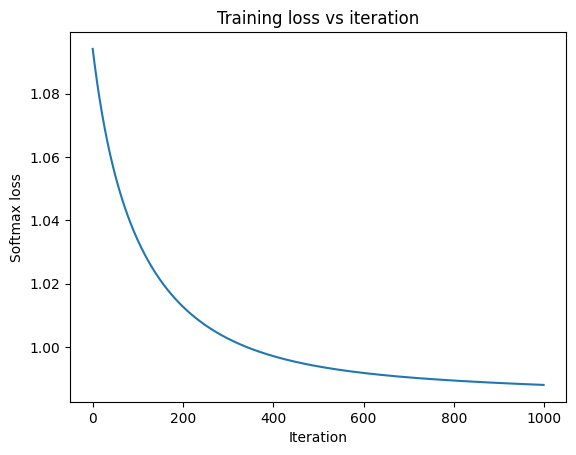

In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(f_hist)
plt.xlabel("Iteration")
plt.ylabel("Softmax loss")
plt.title("Training loss vs iteration")
plt.show() # Plot loss curve